In [ ]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph

# Self-RAG

Self-RAG is a recent paper that introduces an interesting approach for active RAG. 

The framework trains a single arbitrary LM (LLaMA2-7b, 13b) to generate tokens that govern the RAG process:

1. Should I retrieve from retriever, `R` -

* Token: `Retrieve`
* Input: `x (question)` OR `x (question)`, `y (generation)`
* Decides when to retrieve `D` chunks with `R`
* Output: `yes, no, continue`

2. Are the retrieved passages `D` relevant to the question `x` -

* Token: `ISREL`
* * Input: (`x (question)`, `d (chunk)`) for `d` in `D`
* `d` provides useful information to solve `x`
* Output: `relevant, irrelevant`


3. Are the LLM generation from each chunk in `D` is relevant to the chunk (hallucinations, etc)  -

* Token: `ISSUP`
* Input: `x (question)`, `d (chunk)`,  `y (generation)` for `d` in `D`
* All of the verification-worthy statements in `y (generation)` are supported by `d`
* Output: `{fully supported, partially supported, no support`

4. The LLM generation from each chunk in `D` is a useful response to `x (question)` -

* Token: `ISUSE`
* Input: `x (question)`, `y (generation)` for `d` in `D`
* `y (generation)` is a useful response to `x (question)`.
* Output: `{5, 4, 3, 2, 1}`

We can represent this as a graph:

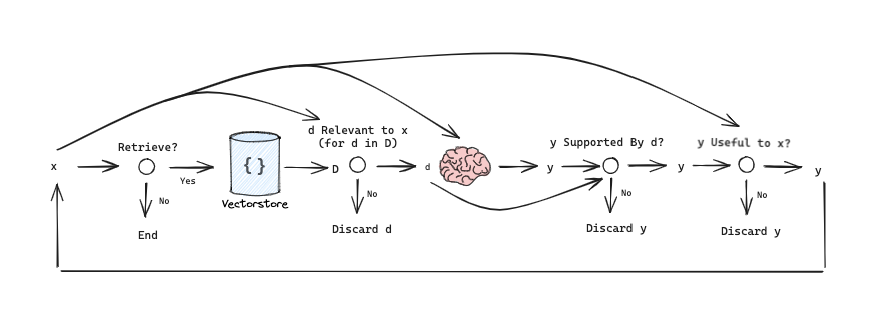

Paper -
https://arxiv.org/abs/2310.11511

## Retriever

In [272]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

## LLM

In [273]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-0125-preview")

## State
 
We will define a graph.

Our state will be a `dict`.

We can access this from any graph node as `state['keys']`.

In [274]:
from typing import Dict, TypedDict

from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    """
    Represents the state of an agent in the conversation.

    Attributes:
        keys: A dictionary where each key is a string and the value is expected to be a list or another structure
              that supports addition with `operator.add`. This could be used, for instance, to accumulate messages
              or other pieces of data throughout the conversation.
    """

    keys: Dict[str, any]

## Nodes and Edges

Each node will - 

1/ Either be a function or a runnable.

2/ Modify the `state`.

The edges choose which node to call next.

We can lay out self-RAG as a graph:

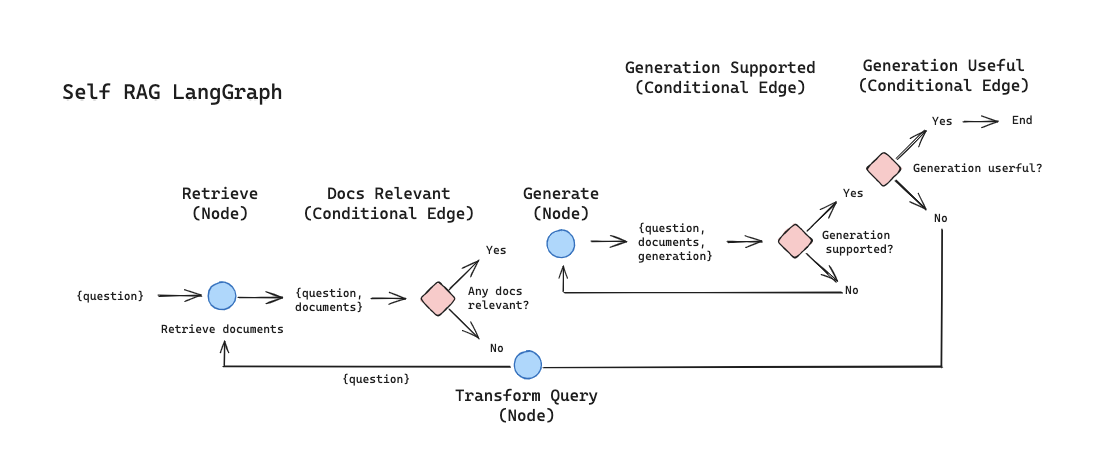

In [332]:
import json
import operator
from typing import Annotated, Sequence, TypedDict

from langchain import hub
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain_community.vectorstores import Chroma
from langchain_core.messages import BaseMessage, FunctionMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.prebuilt import ToolInvocation


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        dict: New key added to state, documents, that contains documents.
    """
    print("---RETRIEVE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = retriever.get_relevant_documents(question)
    return {"keys": {"documents": documents, "question": question}}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        dict: New key added to state, generation, that contains generation.
    """
    print("---GENERATE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {
        "keys": {"documents": documents, "question": question, "generation": generation}
    }


### Continue

## Graph

In [333]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("generate", generate)  # generatae

# Flow
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)

### Continue

# Compile
app = workflow.compile()

In [334]:
from langchain_core.messages import HumanMessage

inputs = {
    "keys": {
        "question": "What are the types of agent memory based on Lilian Weng's blog post?"
    }
}
answer = app.invoke(inputs)

---RETRIEVE---
---GENERATE---


In [340]:
answer["keys"]

{'documents': [Document(page_content='Types of Memory\n\nMaximum Inner Product Search (MIPS)\n\n\nComponent Three: Tool Use\n\nCase Studies\n\nScientific Discovery Agent\n\nGenerative Agents Simulation\n\nProof-of-Concept Examples\n\n\nChallenges\n\nCitation\n\nReferences\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examp